# PRACTICA 1 - APRENENTATGE COMPUTACIONAL
Integrants: Álvaro Díaz 1639484, Jan Planas 1636492, David Fuentes 1637892

## ANÀLISIS TITANIC


Importació de llibreries útils per la pràctica. Compararem resultats entre tres tipus de classificadors diferents. En aquest cas, són: KNN, Random Forest i SVC.

In [109]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import HDBSCAN
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve,roc_auc_score, auc  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, classification_report, average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, OrdinalEncoder, Normalizer, OneHotEncoder

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

## 1. EDA - Exploratory data analysis

En aquest apartat farem un analisis complert de les dades. 

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.info()
print()
test_data.info()
print()
print(f"El shape del train-data es {train_data.shape}.")
print(f"El shape del test-data es {test_data.shape}.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass 

Aquesta serà la nostra primera visualització de les característiques dels dos datasets. Podem distingir diversa informació important com el shape, el nom dels atributs, la cantitat de valors non-null i els tipus d'atributs. 

La mesura dels datasets és la que es mostrà al output. Pel train, 891 mostres amb 12 atributs cadascuna i al test es redueix a la meitat de mostres amb 418 i 11 atributs. Aquest petita diferència als atributs l'explicarem a continuació. Per altra banda, els atributs es podem distribuir en numèrics i categòrics. Entre els numèrics tenim: Age, SibSp, Parch i Fare. Pels categòrics tenim: Survived, que també la podem classificar com binaria, Pclass, Sex, Ticket, Cabin i Embarked. Cal dir que no pel fet de ser de tipus int64 o float64 significa que siguin numèriques. Depen del contexte podem tenir altre valor.

Respecte el target d'aquest analisis, estarem intentant predir el valor corresponent a la columna Survived de les dades del conjunt de test. Aquest atribut el podem classificar com binari perquè ha de predir Survived = 1 i no-Survived = 0.

Per finalitzar, podem veure també que els dos datasets princiapls són una mica diferents. A diferència del train, el test no té la columna Survived. Això és degut a que amb el test hem de predir aquesta columna que després es comprovarà amb el dataset 'gender_submission.csv' on trobem els valors reals que haurien de donar les 418 prediccions del conjunt de test. Per deixar-les igualades, ficarem una columna Survived al test que tindrà valors NaNs.

In [3]:
test_data['Survived'] = np.NaN

La funció info() ja ho mostrava, pero per més claretat, anem a veure si tenim NaNs als nostres datasets.

In [4]:
print(train_data.isna().sum())
print()
print(test_data.isna().sum())

'''def get_percentage_nan_per_column(df):
  #retorna un df amb el % de nans de cada columna
  return df.isna().sum().sort_values()/len(df)*100.

percentage_nan = get_percentage_nan_per_column(titanic_data)
percentage_nan'''

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived       418
dtype: int64


'def get_percentage_nan_per_column(df):\n  #retorna un df amb el % de nans de cada columna\n  return df.isna().sum().sort_values()/len(df)*100.\n\npercentage_nan = get_percentage_nan_per_column(titanic_data)\npercentage_nan'

Podem veure com tenim valors NaN a les columnes de Age i Cabin per tots dos datasets i Embarked únicament pel train. Sabent això, més endavant podrem decidir que fer amb aquests valors.

Caldria fer un analisi més visual. Utilitzem la llibreria matplotlib. Voldrem entrendre les distribucions de les variables numèriques i categoriques i comparar-les amb el target per veure correlacions. 

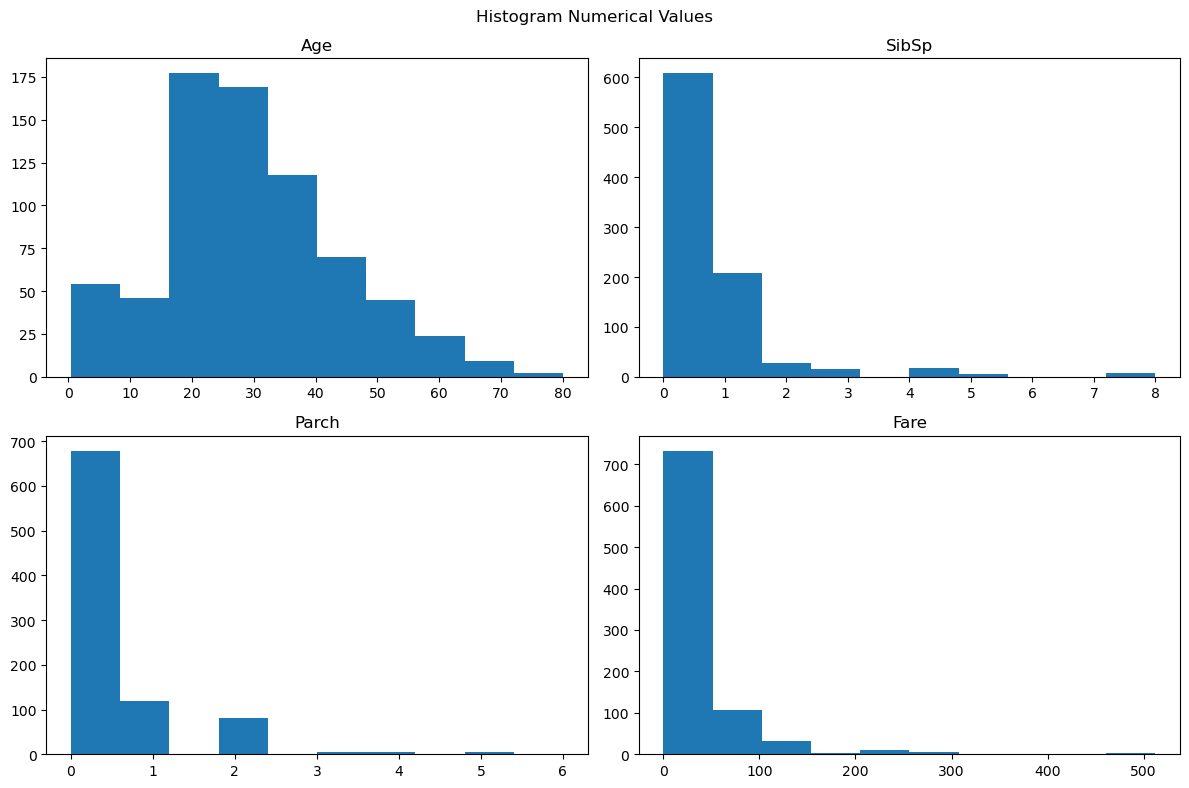

In [5]:
df_num = train_data[['Age','SibSp','Parch','Fare']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()
plt.show()

En aquest histogrames de atributs numérics, el que més destaca principalment es la distribució del Fare totalment desproporcionada, encara que també ho estan SibSp i Parch. En el cas de Age, esta bastant bé distribuit.

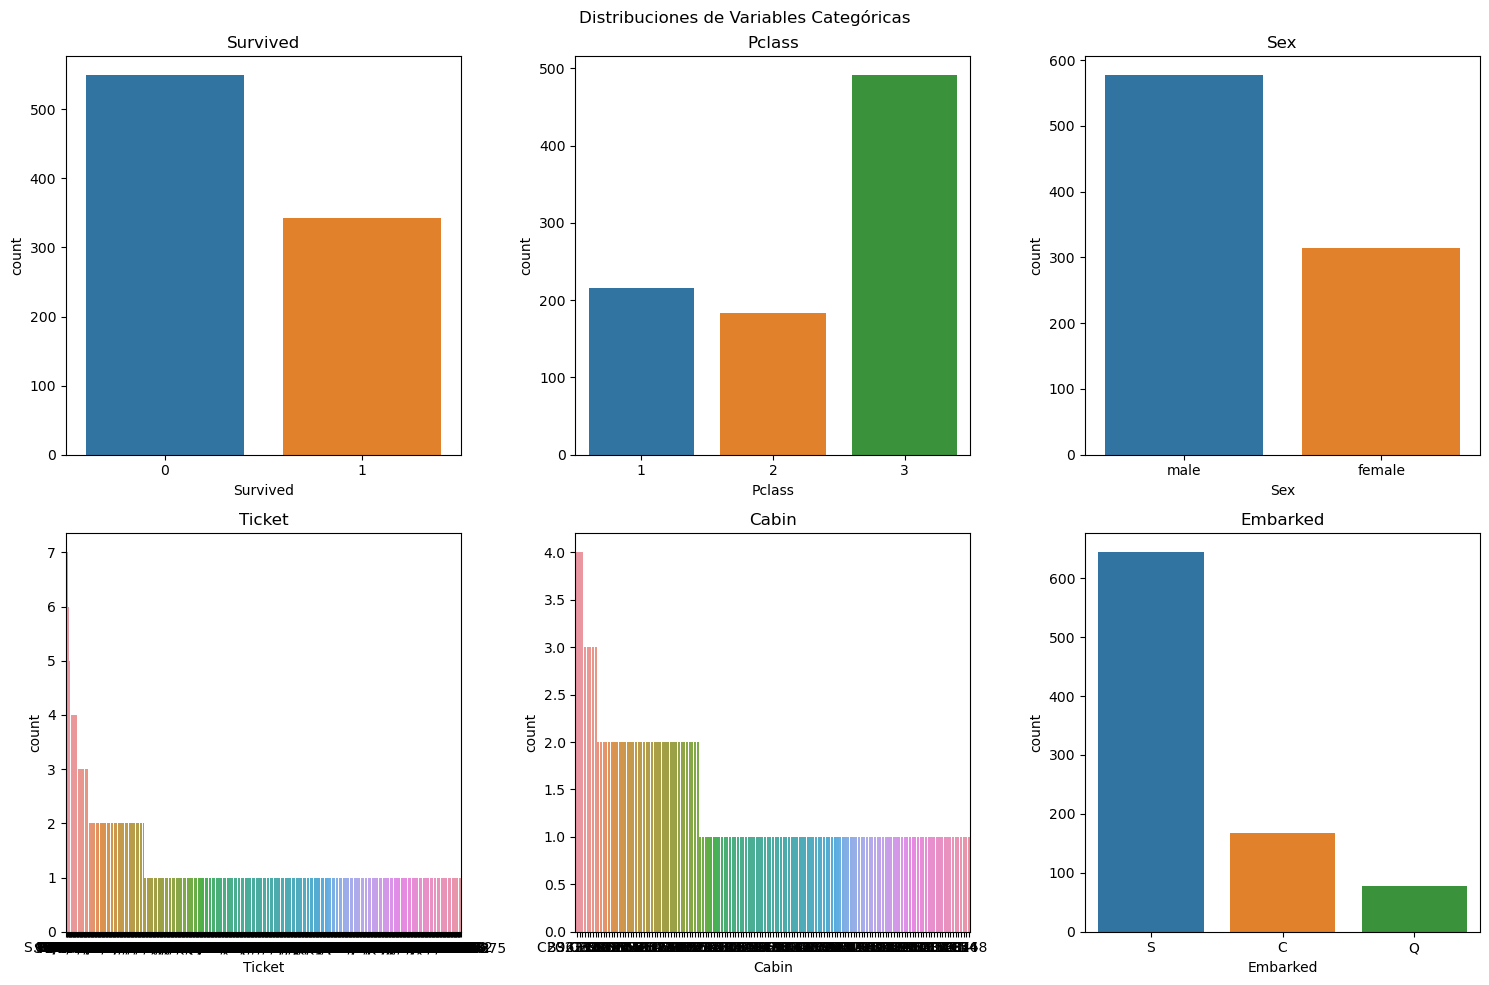

In [6]:
df_cat = train_data[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribuciones de Variables Categóricas')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Aquesta seria la distribució de cada atribut categòric, inclús el target, on podem veure que a Ticket i Cabin tenen molts valors diferents pel que no ens serveix com per analitzar les correlacions amb survived. Name directament al tenir tot valors únics, no el podem analitzar com aquest altres. En cas de la resta, la distribució mostra una classe predominant sempre. Per exemple, a Survived i a més No-Survived que Survived, que té sentit. A Pclass la classe 3 és la més normal, es a dir, persones que han pujat al vaixell en tercera classe. Els hombres també predominaven i la majoria va embarcar a Southampton. En aquests casos, a diferencia de les numèriques, no afectaria en gran mesura a la classificació perquè tenen valors no molt diferents, excepte Embarked.

Pel cas de les correlacions, mirarem primer las variables númeriques.

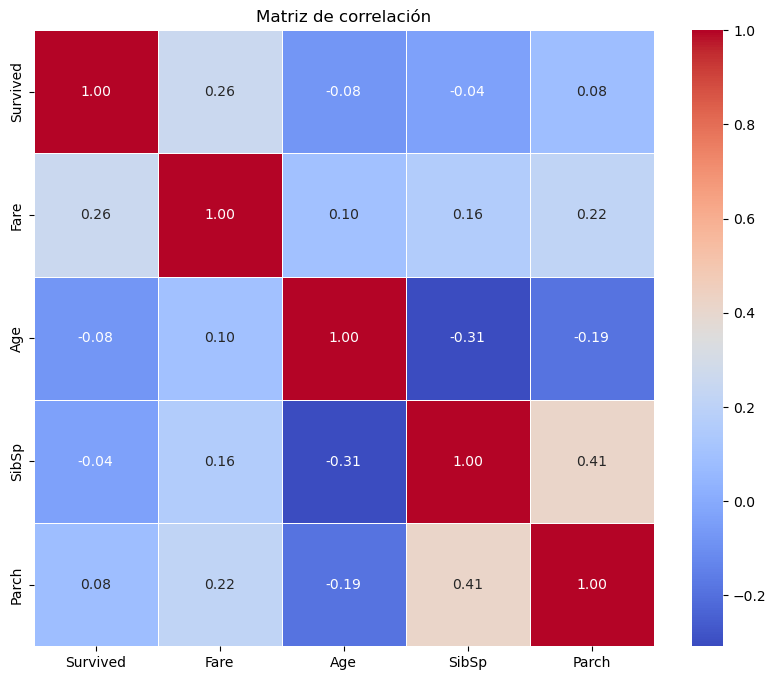

In [7]:
correlation_matrix = train_data[['Survived', 'Fare', 'Age', 'SibSp', 'Parch']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación')
plt.show()

Com volem veure únimcament la correlació que tenen els atributs amb el target, aillarem la primera fila, que ens dona com a resultat el següent:

In [8]:
first_row_correlation = correlation_matrix.iloc[0]
first_row_correlation_matrix = pd.DataFrame([first_row_correlation])
first_row_correlation_matrix

,Survived,Fare,Age,SibSp,Parch
Survived,1.0,0.257307,-0.077221,-0.035322,0.081629


Com podem veure, els atributs numèrics que tenen correlació amb la variable Survived son Fare i Parch. Com tots dos son atributs desproporcionats en quant a dades, pot ser caldrà normalitzar més endavant.

Ara mirarem pel cas de les variables categòriques.

Farem una petita adaptació i la variable Sex la convertirem a binaria per veure millor la correlació entre Survived i aquesta.

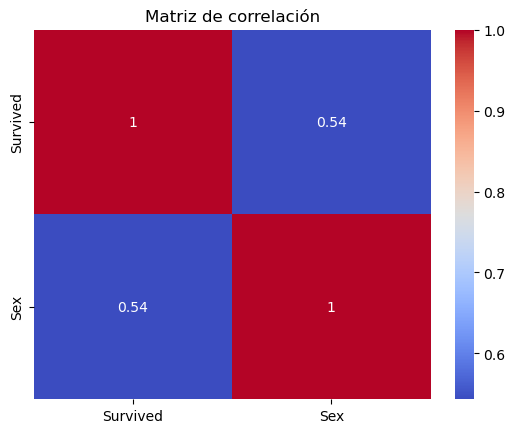

In [9]:
titanic_data = train_data[['Survived', 'Sex']]

titanic_data["Sex"] = titanic_data["Sex"].replace({"male": 0, "female": 1})

correlation_matrix = titanic_data.corr()
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

A aquesta matriu, podem observar com el Sexe té molta correlació amb el target amb un 0,54. Caldria veure quina es la proporció per cada clase dins d'aquest atribut i tenir-ho en compte més endavant.

Si ho mirem d'altre forma amb altres atributs adicionals, quedaria de la següent forma.

In [10]:
pd.pivot_table(train_data, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [11]:
pd.pivot_table(train_data, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


In [12]:
pd.pivot_table(train_data, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


Aquestes serien les distribucions dels atributs respecte el target Survived. Veiem la correlació de Sex que vam veure abans on la majoria de 0s corresponen amb homes i la majoria d'1s amb dones. A la resta també es poden observar correlacions com que si ets de classe 3 tens més probabilitats de morir. A Embarked, encara que la majoria de morts es troba a S, esta proporcionat amb la resta de classes, per tant, podem veure que la seva correlació es bastant poca. 

## 2. Preprocessing

En aquest apartat procedirem a realitzar una preparació de les dades pel model.

Començarem amb l'eliminació de NaNs. Com ja vam veure abans, als datasets de train i test tenim NaNs a uns quants atributs. Podem decidir que fem amb ells tenint en compte la seva importancia respecte la predicció de Survived.

Abans de fer res, com aquest proces porta a terme l'eliminació de columnes, fill de NaNs... unirem els dos datasets identificant-los amb una columna que ho especifiqui. No ens interessa únicament modificar un sol dataset. Una vegada realitzat, els volverem a "splitejar".

In [76]:
train_data['type_data'] = 'train'
test_data['type_data'] = 'test'

titanic_data = pd.concat([train_data, test_data], ignore_index=True)
titanic_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
type_data         0
dtype: int64

### NaNs Treatment
#### Cabin

Ara volem veure la relació que té la cabina que tens assignada respecte la teva classe com a passatger (Pclass). Hem fet una cerca a internet i hem vist que la lletra de la cabina era per identificar la planta a on et trobaves i las primeres lletres eran las que es trobaven més a dalt, tenint en compte que la A es la coberta.

In [77]:
titanic_data['cabin_letter'] = titanic_data.Cabin.apply(lambda x: str(x)[0])
pd.pivot_table(titanic_data,index='Pclass',columns='cabin_letter', values = 'Name', aggfunc='count')

cabin_letter,A,B,C,D,E,F,G,T,n
Pclass,,,,,,,,,
1,22.0,65.0,94.0,40.0,34.0,NaN,NaN,1.0,67.0
2,NaN,NaN,NaN,6.0,4.0,13.0,NaN,NaN,254.0
3,NaN,NaN,NaN,NaN,3.0,8.0,5.0,NaN,693.0


Mirant aquesta correlació ens adonem que tenim un únic valor que té assignat la T. La resta dels valors amb aquesta classe són NaNs, per tant, hem decidit obviar-ho i eliminar aquesta única fila. A més que cercant a internet no hem trobat cap cabina que contigui la lletra T, així que suposem que és un error.

La següent funció, emplena els NaNs que trobem a la categoria Cabina (on hi més percentatge de NaNs). No hem considerat la seva eliminació perquè ho considerem un element clau per a la predicció final. Tenim en consideració que quan més alta es la classe, més a dalt et trobaves.

In [78]:
import random
def agregar_probabilidades_planta(dataframe):
    # Función para asignar probabilidades según la clase
    def asignar_planta(row):
        if row['cabin_letter'] != 'n':
            return ord(str(row['cabin_letter'])) - 64
        pclass = row['Pclass']
        if pclass == 1:
            return random.choices([1, 2, 3, 4, 5], weights=[0.05, 0.3, 0.4, 0.15, 0.1])[0]
        elif pclass == 2:
            return random.choices([3, 4, 5, 6], weights=[0.2, 0.3, 0.3, 0.2])[0]
        elif pclass == 3:
            return random.choices([5, 6, 7], weights=[0.2, 0.4, 0.4])[0]

    # Aplicar la función a las filas del DataFrame para obtener la planta asignada
    dataframe['Floor'] = dataframe.apply(asignar_planta, axis=1)
    
    return dataframe

titanic_data['cabin_letter'] = titanic_data.Cabin.apply(lambda x: str(x)[0])

# Llama a la función para agregar la columna
titanic_data = agregar_probabilidades_planta(titanic_data)
titanic_data = titanic_data[titanic_data['Floor'] != 20] # eliminacio del valor únic

# Muestra el DataFrame resultante
print(titanic_data.isna().sum())
pd.pivot_table(titanic_data, index = 'Pclass', columns = 'Floor', values = 'Ticket' ,aggfunc ='count')

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age              263
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin           1014
Embarked           2
type_data          0
cabin_letter       0
Floor              0
dtype: int64


Floor,1,2,3,4,5,6,7
Pclass,,,,,,,
1,24.0,87.0,117.0,53.0,41.0,NaN,NaN
2,NaN,NaN,42.0,95.0,85.0,55.0,NaN
3,NaN,NaN,NaN,NaN,134.0,273.0,302.0


El resultat ens mostra com ja omplert les dades, on la suma total ens donarà la quantitat exacta de files que tenim menys una. Per millor comprensió hem canviat las lletres per números i ho hem assignat al atribut Floor. Cabin ja no ens servirà i per tant, ho podrem eliminar.

Com a petita justificació de l'eliminació del Cabin després d'aquest fill podem dir que d'aquesta columna només ens interesava la lletra. El valor numèric no donava res d'informació pel que hem cercat a la web. No tenia relació directa amb la classe o posició dins del titanic, per tant, ja no farem servir més aquesta columna. 

In [79]:
titanic_data = titanic_data.drop(['Cabin', 'cabin_letter'], axis = 1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1308 non-null   int64  
 1   Survived     890 non-null    float64
 2   Pclass       1308 non-null   int64  
 3   Name         1308 non-null   object 
 4   Sex          1308 non-null   object 
 5   Age          1045 non-null   float64
 6   SibSp        1308 non-null   int64  
 7   Parch        1308 non-null   int64  
 8   Ticket       1308 non-null   object 
 9   Fare         1307 non-null   float64
 10  Embarked     1306 non-null   object 
 11  type_data    1308 non-null   object 
 12  Floor        1308 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.1+ KB


#### Embarked

La següent columna amb NaNs que tractarem és Embarked on trobem únicament dos a tot el dataset. 

In [80]:
pd.pivot_table(titanic_data,index='Embarked',columns='Pclass', values = 'Ticket', aggfunc='count') 

Pclass,1,2,3
Embarked,,,
C,141,28,101
Q,3,7,113
S,176,242,495


In [81]:
titanic_data[titanic_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,type_data,Floor
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,train,2
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,train,2


Al ser els dos nans de la Pclass 1 hem decidit omplir-los amb el valor Embarked C ja que és on per proporció es hi ha més gent de la Pclass 1.

In [82]:
titanic_data.loc[titanic_data['Embarked'].isna(), 'Embarked'] = 'S'
print(titanic_data.isna().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         0
type_data        0
Floor            0
dtype: int64


#### Fare

Continuem amb l'atribut Fare. Aquest té un únic NaN, pel que l'únic que podriem fer seria omplir-ho amb la mitjà i deixar-ho estar. No obstant, el que volem és que s'aproximi el màxim possible al valor real que hauria de tenir, com hem fet a la resta de fills, així doncs farem el següent. Omplim el valor Fare amb la mitjà dels valors que tenen en comú la classe de Pclass del NaN.

In [83]:
media_fare_class = titanic_data.groupby('Pclass')['Fare'].agg(['mean', 'std','count'])
for pclass, fare_mean in media_fare_class['mean'].items():
        titanic_data.loc[(titanic_data['Pclass'] == pclass) & (titanic_data['Fare'].isna()), 'Fare'] = fare_mean
print(titanic_data.isna().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
type_data        0
Floor            0
dtype: int64


#### Age
Per últim, farem el fill dels Age. La idea principal d'aquest tractament de NaNs es fer un fill segons una aproximació de edats a partir dels titols dels noms que té cadascú.

In [84]:
titanic_data['name_title'] = titanic_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title

name_title
Capt              0
Col               0
Don               0
Dona              0
Dr                1
Jonkheer          0
Lady              0
Major             0
Master            8
Miss             50
Mlle              0
Mme               0
Mr              176
Mrs              27
Ms                1
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

El que hem fet primer és crear un nou atribut que té com a classes els títols dels nombres que ens servirà per classificar les edats de cadascuna de les persones. Com veiem, tenim un baix percentatge de NaNs a Dr, Master, Miss, Mrs i Ms. Mr té quasi quatre vegades més NaNs que Miss per tant, aplicarem una tècnica de fill diferent.

Pel baix percentatge, l'únic que farem serà omplir amb la mitjà d'edat de les persones que tenen el mateix name_title.

In [85]:
media_por_name_title = titanic_data.groupby('name_title')['Age'].agg(['mean', 'std','count'])
media_por_name_title

,mean,std,count
name_title,,,
Capt,70.000000,NaN,1
Col,54.000000,5.477226,4
Don,40.000000,NaN,1
Dona,39.000000,NaN,1
Dr,43.571429,11.731115,7
Jonkheer,38.000000,NaN,1
Lady,48.000000,NaN,1
Major,48.500000,4.949747,2
Master,5.482642,4.161554,53


In [86]:
def agregar_probabilidades_edad(dataframe, media_por_name_title):
    # Función para asignar probabilidades según la clase
    def asignar_edad(row):
        if pd.isna(row['Age']) == True and row['name_title'] != 'Mr':
            return round(media_por_name_title['mean'][row['name_title']])
        return row['Age']

    dataframe['Age'] = dataframe.apply(asignar_edad, axis=1)

    return dataframe

titanic_data = agregar_probabilidades_edad(titanic_data, media_por_name_title)

nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title


name_title
Capt              0
Col               0
Don               0
Dona              0
Dr                0
Jonkheer          0
Lady              0
Major             0
Master            0
Miss              0
Mlle              0
Mme               0
Mr              176
Mrs               0
Ms                0
Rev               0
Sir               0
the Countess      0
Name: Age, dtype: int64

Com veiem, hem omplert tots els NaNs que no són de Mr. 

Ara, farem una clusterització. Agafarem totes les persones amb name_title = Mr i farem un HDBSCAN per classificar-los. Després, agafarem la mitja d'edat cadascun dels clusters i omplirem els NaNs que ens falten en funció del cluster on es classifica. 

Cluster 0 Attributes:
      Pclass  Sex  SibSp  Parch      Fare  Floor
27         1    1      3      2  263.0000      3
118        1    1      0      1  247.5208      2
377        1    1      0      2  211.5000      3
438        1    1      1      4  263.0000      3
527        1    1      0      0  221.7792      3
557        1    1      0      0  227.5250      2
966        1    1      0      0  211.5000      3
972        1    1      1      0  221.7792      3
1033       1    1      1      3  262.3750      2
1298       1    1      1      1  211.5000      3


Cluster 1 Attributes:
     Pclass  Sex  SibSp  Parch      Fare  Floor
390       1    1      1      2  120.0000      2
505       1    1      1      0  108.9000      3
544       1    1      1      0  106.4250      3
550       1    1      0      2  110.8833      3
659       1    1      0      2  113.2750      4
698       1    1      1      1  110.8833      3


Cluster 2 Attributes:
      Pclass  Sex  SibSp  Parch     Fare  Floor
224    

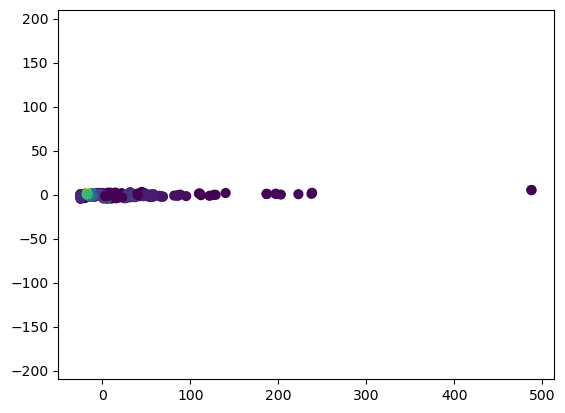

In [88]:
mr_ages = titanic_data[(titanic_data['name_title'] == 'Mr')]
titanic_data["Sex"] = titanic_data["Sex"].replace({"male": 1, "female": 0})
mr_ages = mr_ages[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Floor']]

def plot_hdbscan(X, min_cluster_size=5, rseed=0, ax=None):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X)

    clusterer = HDBSCAN(min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    cluster_labels = set(labels)
    index_clusters = {}
    
    for label in cluster_labels:
        cluster_data = X[labels == label]
        print(f"Cluster {label} Attributes:")
        index_clusters[label] = cluster_data.index
        print(cluster_data)
        print("\n")
    
    return index_clusters, labels

# Utiliza la función plot_hdbscan con tus datos
index_clusters, labels = plot_hdbscan(mr_ages)

Tindrem com a resultat aquesta gràfica. Aquesta és resultat de fer proves manualment al número de clusters i hem decidit que aquest es el millor paràmetre.

Ara cal omplir els NaNs de Age amb els resultats obtinguts.

In [89]:
cluster_means = {}
for label, index_cluster in index_clusters.items():
    cluster_ages = titanic_data.loc[index_cluster, 'Age']
    cluster_mean_age = round(cluster_ages.mean())
    cluster_means[label] = cluster_mean_age
    print(f"Media de edades para Cluster {label}: {cluster_mean_age}")
    titanic_data.loc[index_cluster, 'Age'] = titanic_data.loc[index_cluster, 'Age'].fillna(cluster_mean_age)
print("Min age: ", min(cluster_means.values()))
print("Max age: ", max(cluster_means.values()))

Media de edades para Cluster 0: 43
Media de edades para Cluster 1: 38
Media de edades para Cluster 2: 38
Media de edades para Cluster 3: 35
Media de edades para Cluster 4: 32
Media de edades para Cluster 5: 43
Media de edades para Cluster 6: 29
Media de edades para Cluster 7: 40
Media de edades para Cluster 8: 36
Media de edades para Cluster 9: 30
Media de edades para Cluster 10: 45
Media de edades para Cluster 11: 41
Media de edades para Cluster 12: 44
Media de edades para Cluster 13: 39
Media de edades para Cluster 14: 31
Media de edades para Cluster 15: 28
Media de edades para Cluster 16: 36
Media de edades para Cluster 17: 35
Media de edades para Cluster 18: 34
Media de edades para Cluster 19: 47
Media de edades para Cluster 20: 30
Media de edades para Cluster 21: 34
Media de edades para Cluster 22: 25
Media de edades para Cluster 23: 30
Media de edades para Cluster 24: 24
Media de edades para Cluster 25: 30
Media de edades para Cluster 26: 25
Media de edades para Cluster 27: 28
Me

In [90]:
nan_counts_by_title = titanic_data.groupby('name_title')['Age'].apply(lambda x: x.isna().sum())
nan_counts_by_title

name_title
Capt            0
Col             0
Don             0
Dona            0
Dr              0
Jonkheer        0
Lady            0
Major           0
Master          0
Miss            0
Mlle            0
Mme             0
Mr              0
Mrs             0
Ms              0
Rev             0
Sir             0
the Countess    0
Name: Age, dtype: int64

In [91]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1308 non-null   int64  
 1   Survived     890 non-null    float64
 2   Pclass       1308 non-null   int64  
 3   Name         1308 non-null   object 
 4   Sex          1308 non-null   int64  
 5   Age          1308 non-null   float64
 6   SibSp        1308 non-null   int64  
 7   Parch        1308 non-null   int64  
 8   Ticket       1308 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1308 non-null   object 
 11  type_data    1308 non-null   object 
 12  Floor        1308 non-null   int64  
 13  name_title   1308 non-null   object 
dtypes: float64(3), int64(6), object(5)
memory usage: 185.6+ KB


Com a resultat, tenim totes les categories omplenades segons les relacions que tenen amb la resta de dades i en un contexte correcte amb diferents mètodes que permeten aproximar-nos encara més a un valor que sigui el més realista possible.

El principal motiu de no eliminar cap columna del nostre dataset es per no perdre posibles relacions entre categories que porten a un millor rendiment del nostre model. Encara que la quantiat de NaNs sigui molt petita, per entrenar millor el model, ens convé no el·liminar les files ni les columnes amb un gran percentatge de missing values ja que perdem dades importants.   

### Feature Selection

Altre procediment important abans de realitzar l'entrenament dels nostres models és la selecció de característiques. Dins del nostre dataset n'hi han columnes de dades que són totalment irrellevants per l'aprenentatge del classificador. Una d'aquestes és la de PassengerId on únicament s'ens informa del index de la mostra sense cap correlació amb qualsevol altra dada del dataset. No obstant, altres característiques caldria especificar en detall perquè són el·liminades.

Anem a veure la posible correlació entre l'atribut Ticket i Survived. Al ser una variable categòrica ens fixarem en si que tiquet està format per números només o per números i lletres i veurem els resultats. En cas de que no ens aporti informació nova, eliminarem la columna Ticket ja que no ens servirà per al nostre model.

In [92]:
titanic_data['Numerical_ticket'] = titanic_data.Ticket.apply(lambda x: 1 if x.isdigit() else 0)
pd.pivot_table(titanic_data,index='Numerical_ticket',columns='Survived', values = 'Ticket', aggfunc='count')

Survived,0.0,1.0
Numerical_ticket,,
0,142,88
1,406,254


Com podiem intuir, la relació entre Numerical_ticket i Survived no ens aporta molta informació ja que als dos possibles casos, els resultats són proporcionals. Això vol dir que per al nostre model la variable Ticket no ens ajudarà a predir millor i la eliminarem per així aconseguir reduir la dimensionalitat del dataset i que sigui menys complexe.

Finalment també hem decidit eliminar la variable Name, ja que, els noms complets no són gens rellevants però el que si que ens quedarem serà amb el Name_title que ens aporta més informació que l'altre característica.

In [93]:
titanic_data = titanic_data.drop(['Ticket', 'Name', 'PassengerId', 'Numerical_ticket'], axis=1)

In [94]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    890 non-null    float64
 1   Pclass      1308 non-null   int64  
 2   Sex         1308 non-null   int64  
 3   Age         1308 non-null   float64
 4   SibSp       1308 non-null   int64  
 5   Parch       1308 non-null   int64  
 6   Fare        1308 non-null   float64
 7   Embarked    1308 non-null   object 
 8   type_data   1308 non-null   object 
 9   Floor       1308 non-null   int64  
 10  name_title  1308 non-null   object 
dtypes: float64(3), int64(5), object(3)
memory usage: 154.9+ KB


### Normalitzacion

"La normalización logarítmica se usa para transformar datos con distribuciones sesgadas o amplia variabilidad, reduciendo el sesgo y la amplitud de valores. Ayuda a nivelar la distribución, estabilizar la varianza, facilitar la interpretación y preparar datos para ciertos modelos, pero su aplicabilidad depende de la naturaleza de los datos y del contexto del problema."

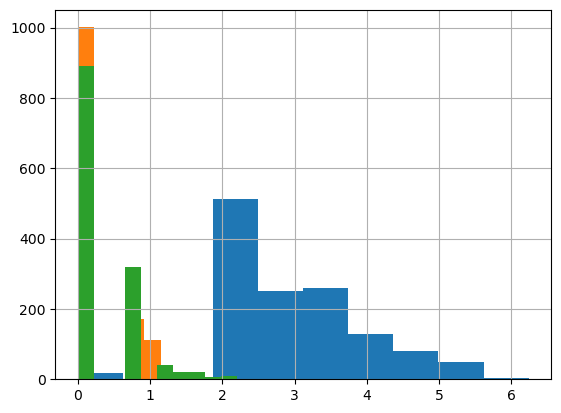

In [95]:
#normalizer = Normalizer()
#titanic_data[['SibSp', 'Parch', 'Fare']] = normalizer.fit_transform(titanic_data[['SibSp', 'Parch', 'Fare']])

titanic_data['Fare_norm'] = np.log(titanic_data.Fare+1)
titanic_data['Fare_norm'].hist()

titanic_data['Parch_norm'] = np.log(titanic_data.Parch+1)
titanic_data['Parch_norm'].hist()

titanic_data['Sibsp_norm'] = np.log(titanic_data.SibSp+1)
titanic_data['Sibsp_norm'].hist()

titanic_data = titanic_data.drop(['SibSp', 'Parch', 'Fare'], axis=1)


In [97]:
titanic_data

,Survived,Pclass,Sex,Age,Embarked,type_data,Floor,name_title,Fare_norm,Parch_norm,Sibsp_norm
0,0.0,3,1,22.0,S,train,6,Mr,2.110213,0.000000,0.693147
1,1.0,1,0,38.0,C,train,3,Mrs,4.280593,0.000000,0.693147
2,1.0,3,0,26.0,S,train,6,Miss,2.188856,0.000000,0.000000
3,1.0,1,0,35.0,S,train,3,Mrs,3.990834,0.000000,0.693147
4,0.0,3,1,35.0,S,train,7,Mr,2.202765,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,29.0,S,test,6,Mr,2.202765,0.000000,0.000000
1305,NaN,1,0,39.0,C,test,3,Dona,4.699571,0.000000,0.000000
1306,NaN,3,1,38.5,S,test,6,Mr,2.110213,0.000000,0.000000
1307,NaN,3,1,29.0,S,test,6,Mr,2.202765,0.000000,0.000000


### Encoding

Per poder entrenar sense problemes el model haurem de fer encoding a les variables categòriques. Les que tenim són: Embarked i Name_title. Hem de buscar una bona forma de fer encoding per obtenir un bon rendiment al model.

Per realitzar aquesta tasca hem de pensar quin encoder utilitzar. En primer lloc, si tenim en compte les dades de Embarked, té tres classes que son C, Q, S. Aquestes corresponen amb els llocs on han embarcat els passatgers del titanic, seguint un recorregut de Southampton, Cherburgo i Queenstown (cercat a internet). Com podem observar, hi ha un ordre intrinsic que podem aprofitar per utilizar un encoder com OrdinalEncoder. Aquest tipus de codificador asigna un número a cada classe de la columna respectant l'ordre especificat o natural. No augmentarà la dimensionalitat de les dades fent més simple el model.

In [99]:
encoder = OrdinalEncoder()

#establecer orden
titanic_data['Embarked_encoded'] = encoder.fit_transform(titanic_data[['Embarked']])
titanic_data = titanic_data.drop(['Embarked'], axis=1)
titanic_data

KeyError: "None of [Index(['Embarked'], dtype='object')] are in the [columns]"

Per la següent classe categorica, name_title, com no segueix cap ordre intrinsic no podem utilitzar la mateixa codificació. El model interpretaria malament les dades i obtindriem un mal rendiment. Altre opció és One Hot Encoder. Ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Encara que augmenta la dimensionalitat de les dades, creime que es la millor opció.

In [100]:
titanic_data_RF = titanic_data.copy()

encoder = OneHotEncoder(sparse=False)
name_title_encoded = encoder.fit_transform(titanic_data[['name_title']])

new_column_names = encoder.get_feature_names_out(input_features=['name_title'])
encoded_df = pd.DataFrame(name_title_encoded, columns=new_column_names, index=titanic_data.index)

titanic_data = titanic_data.drop(['name_title'], axis=1)
titanic_data = pd.concat([titanic_data, encoded_df], axis=1)

titanic_data

,Survived,Pclass,Sex,Age,type_data,Floor,Fare_norm,Parch_norm,Sibsp_norm,Ebarked_encoded,...,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,name_title_Sir,name_title_the Countess
0,0.0,3,1,22.0,train,6,2.110213,0.000000,0.693147,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1,0,38.0,train,3,4.280593,0.000000,0.693147,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,3,0,26.0,train,6,2.188856,0.000000,0.000000,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1,0,35.0,train,3,3.990834,0.000000,0.693147,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,3,1,35.0,train,7,2.202765,0.000000,0.000000,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,29.0,test,6,2.202765,0.000000,0.000000,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1,0,39.0,test,3,4.699571,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,NaN,3,1,38.5,test,6,2.110213,0.000000,0.000000,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1307,NaN,3,1,29.0,test,6,2.202765,0.000000,0.000000,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Podem veure que ha afegit 18 columnes noves que corresponen amb cadascuna de les classes de la categoria name_title. Per tant, com ja hem encoding a les variables categoriques, ja no hi haurà problemes alhora de entrenar el model, encara que classificadors com Random Forest admeten variables categoriques.

Al utilitzar One Hot Encoder, la interpretació dels arbres pot estar afectada. Es per això que hem creat una copia del dataset titanic_data sense fer la transformació per més tard utilitzar al Model Selection aquest dataset i entrenar el model amb Random Forest.

## 3. Metric selection 

In [104]:
titanic_train = titanic_data[titanic_data.type_data == 'train'].drop(['type_data'], axis = 1)
titanic_test = titanic_data[titanic_data.type_data == 'test'].drop(['type_data'], axis = 1)

X_train = titanic_train.drop('Survived', axis='columns')
y_train = titanic_train['Survived']

X_test = titanic_test.drop('Survived' , axis='columns')

Average_precision_score:  0.6914114057460463 

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       548
         1.0       0.79      0.75      0.77       342

    accuracy                           0.83       890
   macro avg       0.82      0.82      0.82       890
weighted avg       0.83      0.83      0.83       890



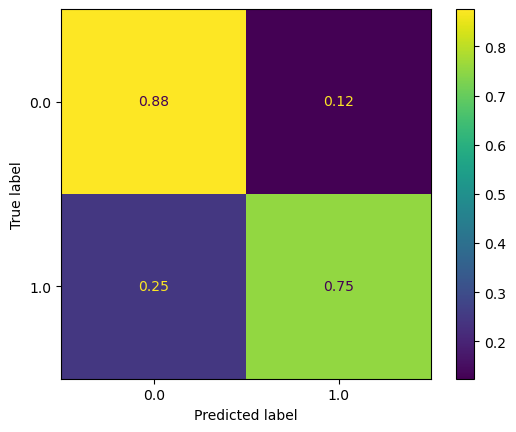

In [110]:
model = LogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_train, y_pred)
confusion = ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize='true')
report = classification_report(y_train, y_pred)
average_precision = average_precision_score(y_train, y_pred)
print("Average_precision_score: ", average_precision, '\n')
print("Informe de Clasificación:")
print(report)

In [111]:
def print_ROC_curve(y ,y_pred):
    roc_score = roc_auc_score(y, y_pred)

    print('ROC AUC=%.3f' % (roc_score))

    ns = [0 for _ in range(len(y))]

    lr_fpr, lr_tpr, _ = roc_curve(y, y_pred)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sense capacitat predictiva')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
    plt.ylabel('Recall')
    plt.xlabel('Specificity')
    
def print_PR_curve(y, y_pred):
    precision, recall, _ = precision_recall_curve(y, y_pred)

    print("Presició: ", precision[1], '\n')
    print("Recall: ", recall[1], '\n')

    area_under_curve = auc(recall, precision)

    plt.plot(recall, precision, marker='.',)
    plt.xlabel('Recall')
    plt.ylabel('Precision')


#### Corba ROC

ROC AUC=0.815


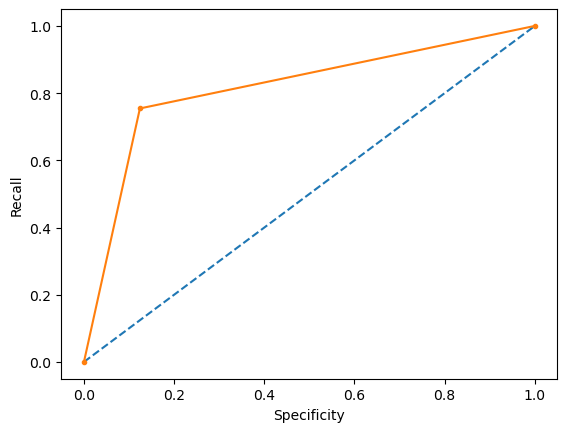

In [112]:
print_ROC_curve(y_train, y_pred)

#### Corba PR

Presició:  0.7914110429447853 

Recall:  0.7543859649122807 



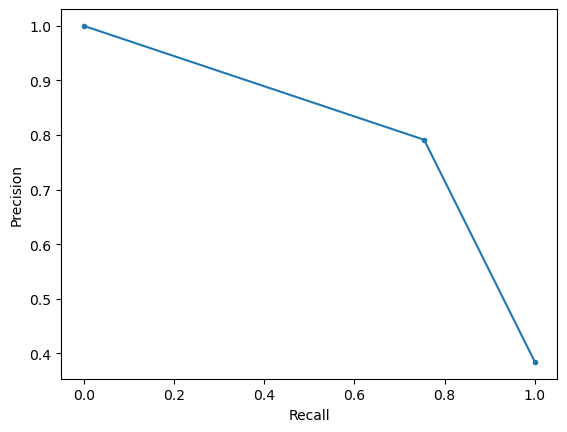

In [113]:
print_PR_curve(y_train, y_pred)